<a href="https://colab.research.google.com/github/robotmasterkris/Kalman-and-Bayesian-Filters-in-Python/blob/master/research/risk_premia/Time_series_momentum_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series momentum effects


In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('RcppRoll', 'lubridate'), extra_dependencies = c("vctrs", "warp", "RcppParallel"))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpE793Se/remotesd424742bac/RWLab-rwRtools-9bce833/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.34.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

# snippet: rw macro quickstart v.0.1
quicksetup(pod = "Macro", path = ".")
head(prices)

Authorization successful!

Set default bucket name to 'macro_research_pod'



Attempting download of  main_asset_classes_daily_ohlc.csv ...
Transferring main_asset_classes_daily_ohlc.csv ... data is 4.8 Mb please be patient...


ℹ Downloading main_asset_classes_daily_ohlc.csv

✔ Saved main_asset_classes_daily_ohlc.csv to ./main_asset_classes_daily_ohlc.cs…





main_asset_classes_daily_ohlc.csv successfully transferred


Rows: 63504 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (6): open, high, low, close, volume, closeadjusted
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,open,high,low,close,volume,closeadjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMB,1995-01-04,40.22193,40.22193,40.22193,40.22193,0,19.41573
GLD,1995-01-04,39.93568,39.93568,39.93568,39.93568,0,39.80411
IEF,1995-01-04,43.80437,43.80437,43.80437,43.80437,0,25.03496
TLT,1995-01-04,40.78683,40.78683,40.78683,40.78683,0,20.41443
VEA,1995-01-04,22.07549,22.07549,22.07549,22.07549,0,13.48354
VTI,1995-01-04,18.97111,18.97111,18.97111,18.97111,0,12.68598


### Historial prices

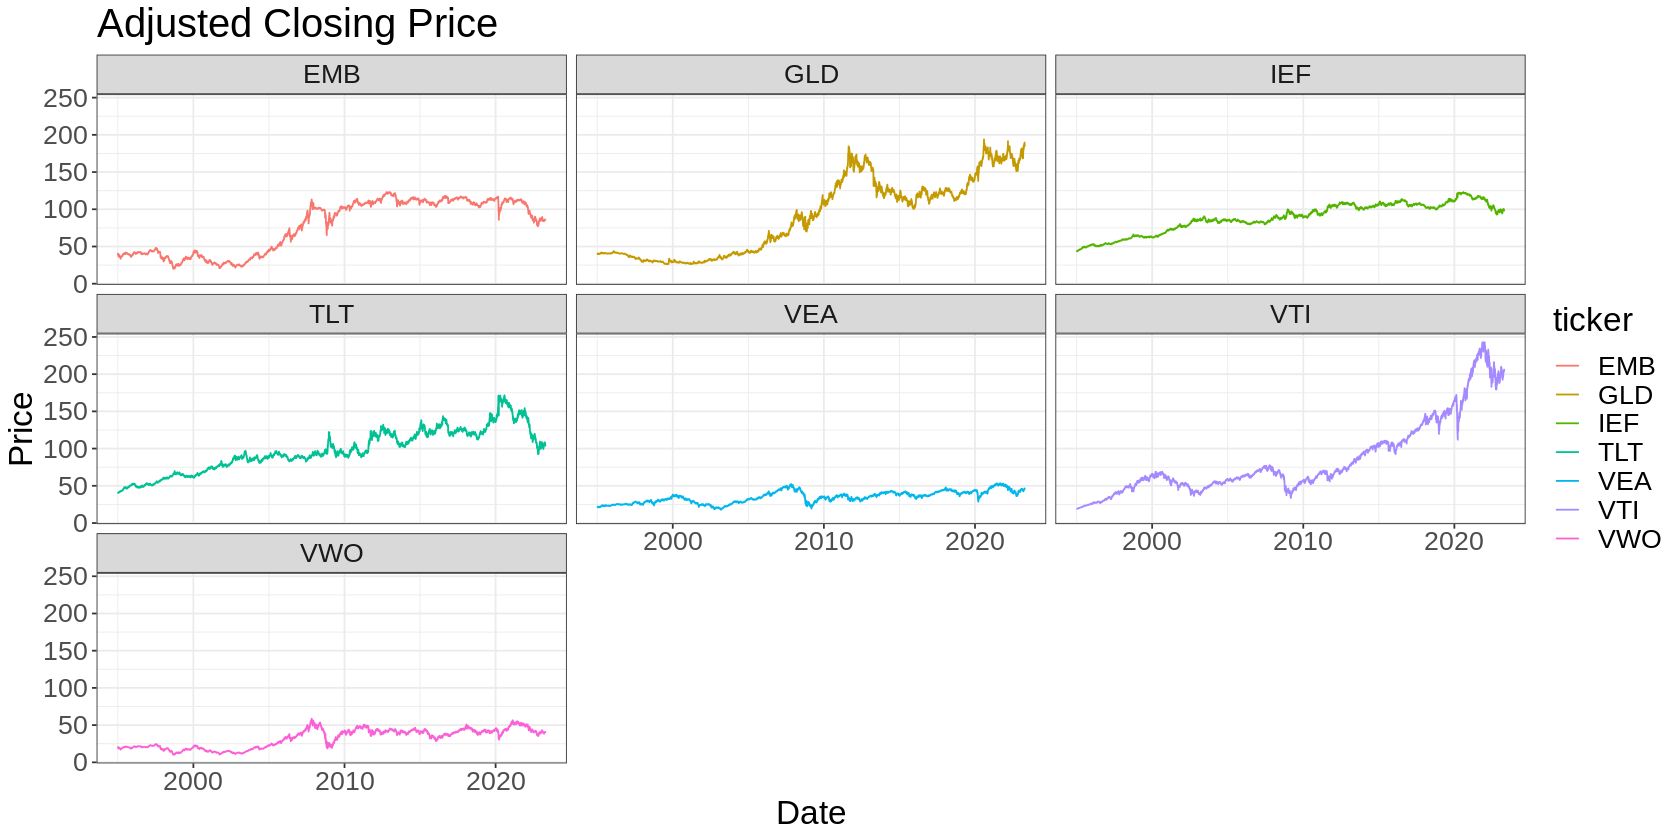

In [3]:
prices <- prices %>%
  dplyr::filter(ticker %in% c('EMB', 'GLD', 'IEF', 'TLT', 'VEA', 'VTI', 'VWO')) 

prices %>%
  ggplot(aes(x = date, y = close, colour = ticker)) +
    geom_line() +
    facet_wrap(~ticker) +
    labs(
      x = "Date",
      y = "Price",
      title = "Adjusted Closing Price"
    )

## Calculate momentum factors and returns

Simple momentum factor - returns over some lookbakc period.

I'll use lookbacks over 4 to 18 months.

Also calculate next day returns. 


In [4]:
momo <- prices %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Calculate momentum features
  # We give the columns the name of the lookback to make things easier when we pivot long
  mutate(
    "4" = (closeadjusted / lag(closeadjusted, 4 * 22) - 1),
    "6" = closeadjusted / lag(closeadjusted, 6 * 22) - 1,
    "8" = closeadjusted / lag(closeadjusted, 8 * 22) - 1,
    "10" = closeadjusted / lag(closeadjusted, 10 * 22) - 1,
    "12" = closeadjusted / lag(closeadjusted, 12 * 22) - 1,
    "14" = closeadjusted / lag(closeadjusted, 14 * 22) - 1,
    "16" = closeadjusted / lag(closeadjusted, 16 * 22) - 1,
    "18" = closeadjusted / lag(closeadjusted, 18 * 22) - 1
  ) %>%
  # Next day returns
  mutate(
    fwd_log_return = log(lead(closeadjusted) / closeadjusted),
    fwd_simple_return = lead(closeadjusted) / closeadjusted - 1
  ) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy (long) format
  pivot_longer("4":"18", names_to = 'lookback', values_to ='momo') %>%
  mutate(lookback = as.numeric(lookback))

head(momo) 

ticker,date,open,high,low,close,volume,closeadjusted,fwd_log_return,fwd_simple_return,lookback,momo
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,4,-0.039705778
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,6,-0.039530618
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,8,0.099329606
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,10,-0.013858543
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,12,-0.057842367
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,14,-0.000938116


Plot momentum vs forward return over all assets by lookback

`geom_smooth()` using formula = 'y ~ x'


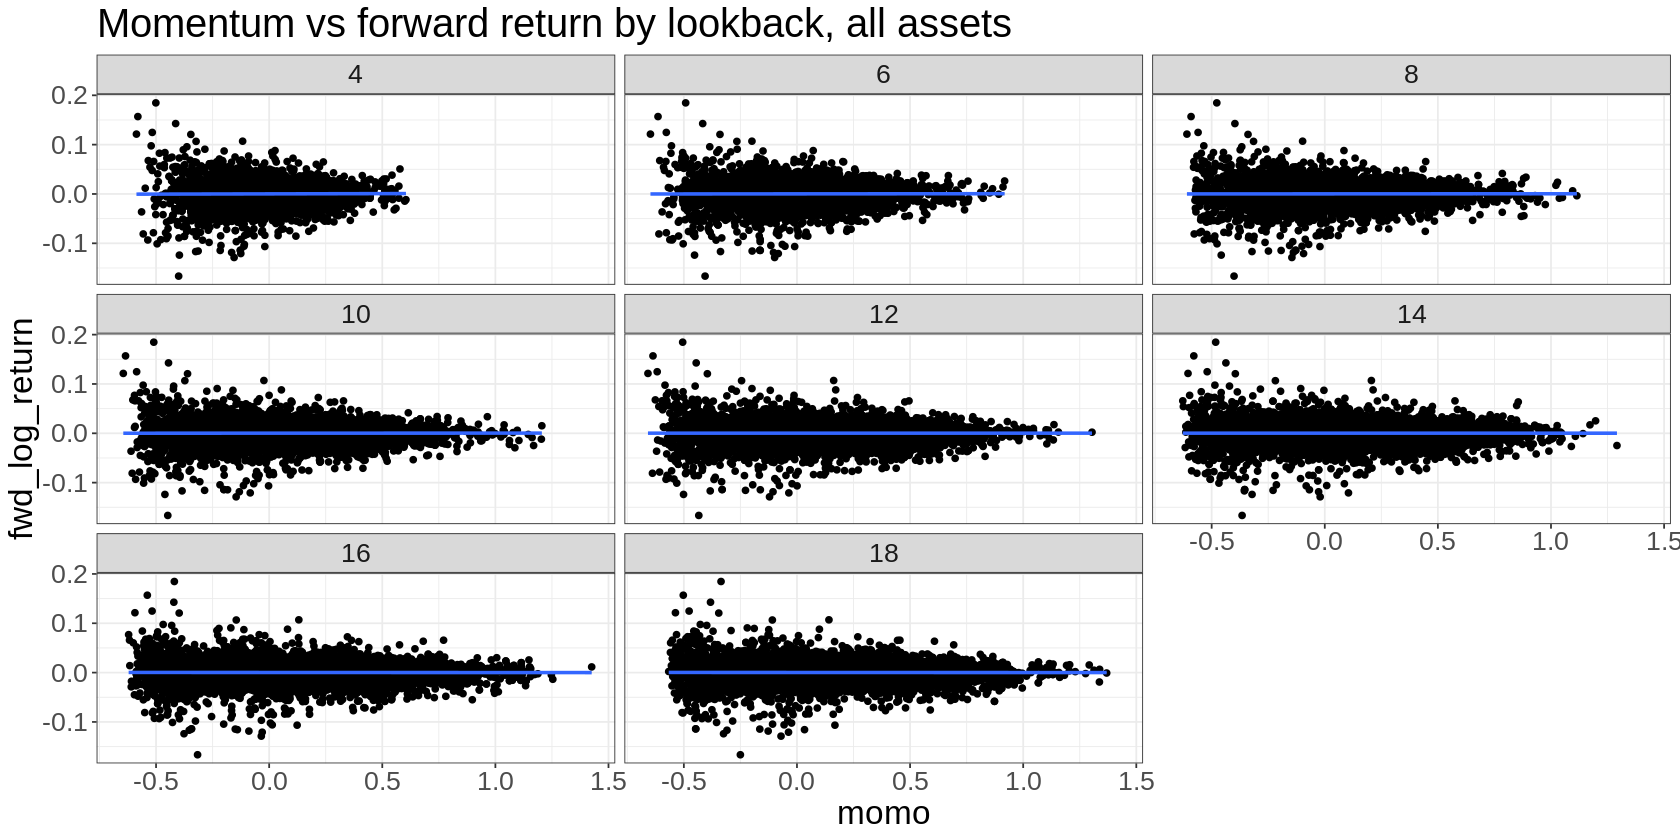

In [5]:
momo %>%
  ggplot(aes(x = momo, y = fwd_log_return)) +
    geom_point() +
    geom_smooth(method = "lm") +
    facet_wrap(~lookback) +
    labs(title = "Momentum vs forward return by lookback, all assets")

Asset-wise momentum not necessarily comparable due to different volatilties. 

Pick a couple of lookbacks and plot by ticker, lookback:

`geom_smooth()` using formula = 'y ~ x'


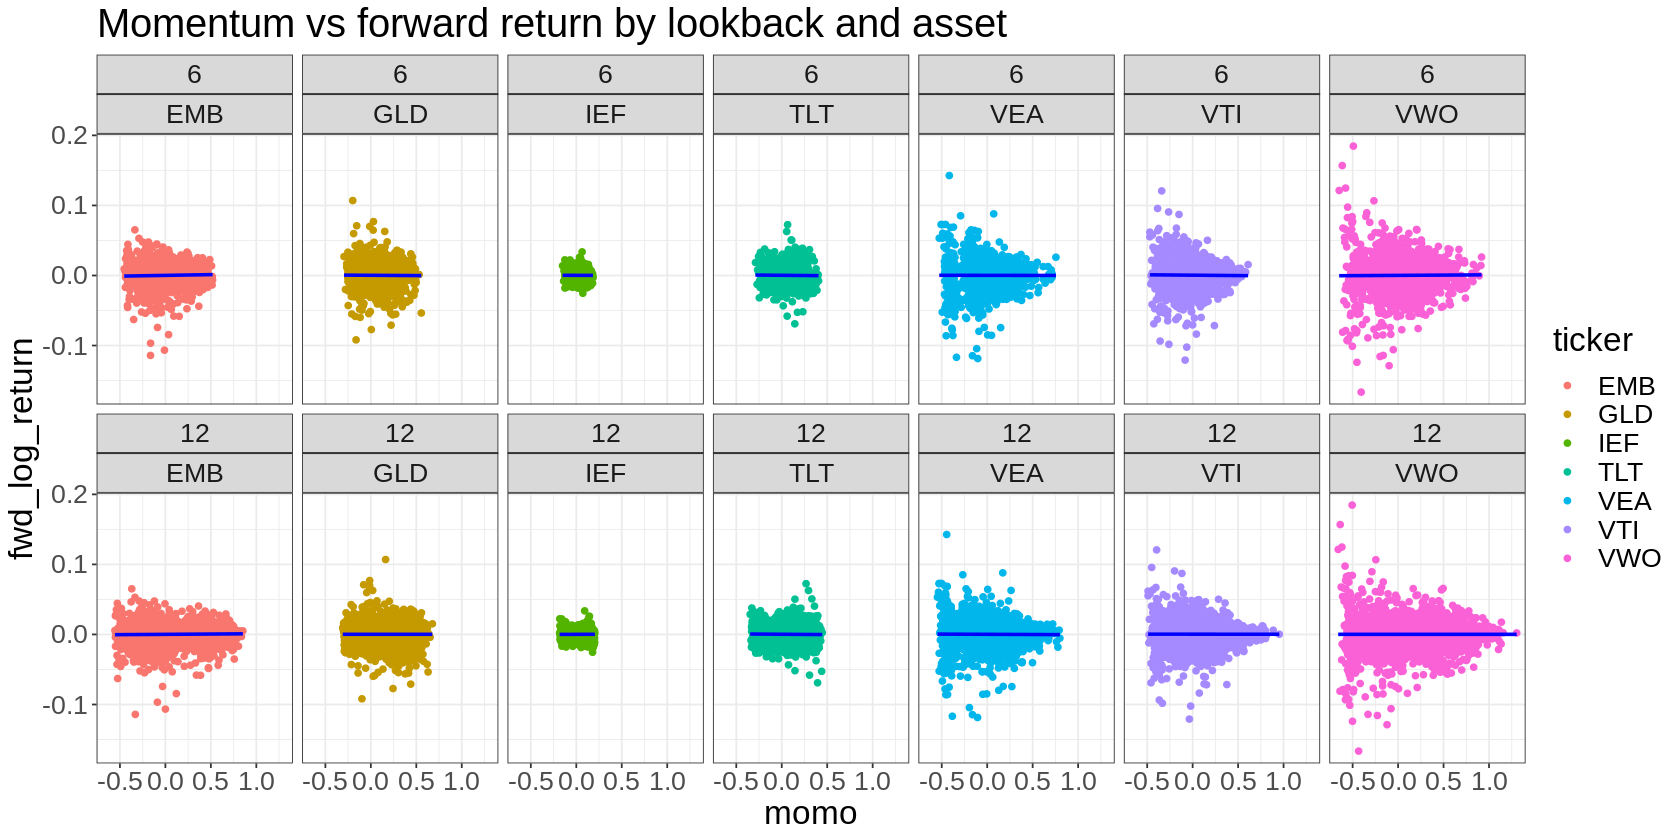

In [6]:
momo %>%
  dplyr::filter(lookback %in% c(6, 12)) %>%
  ggplot(aes(x = momo, y = fwd_log_return, colour = ticker)) +
    geom_point() +
    geom_smooth(method = "lm", colour = "blue") +
    facet_wrap(~lookback + ticker, nrow = 2) +
    labs(title = "Momentum vs forward return by lookback and asset")

### Calculate asset ranks

Bucket momentum by ticker for each lookback. 

All observations fit into n buckets per ticker. 

Compare to cross-sectional approach: observations fit into n_buckets x n_days.

In [7]:
momo <- momo %>%
  group_by(ticker, lookback) %>%
  mutate(
    lookback = factor(lookback),
    rank = factor(ntile(momo, n = 10))
  )

head(momo)

ticker,date,open,high,low,close,volume,closeadjusted,fwd_log_return,fwd_simple_return,lookback,momo,rank
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,4,-0.039705778,3
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,6,-0.039530618,3
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,8,0.099329606,7
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,10,-0.013858543,3
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,12,-0.057842367,3
EMB,1996-07-29,39.47885,39.47885,39.47885,39.47885,0,19.05704,-0.00320193,-0.00319681,14,-0.000938116,4


Ignore ticker and date, sort by rank over full sample. 

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


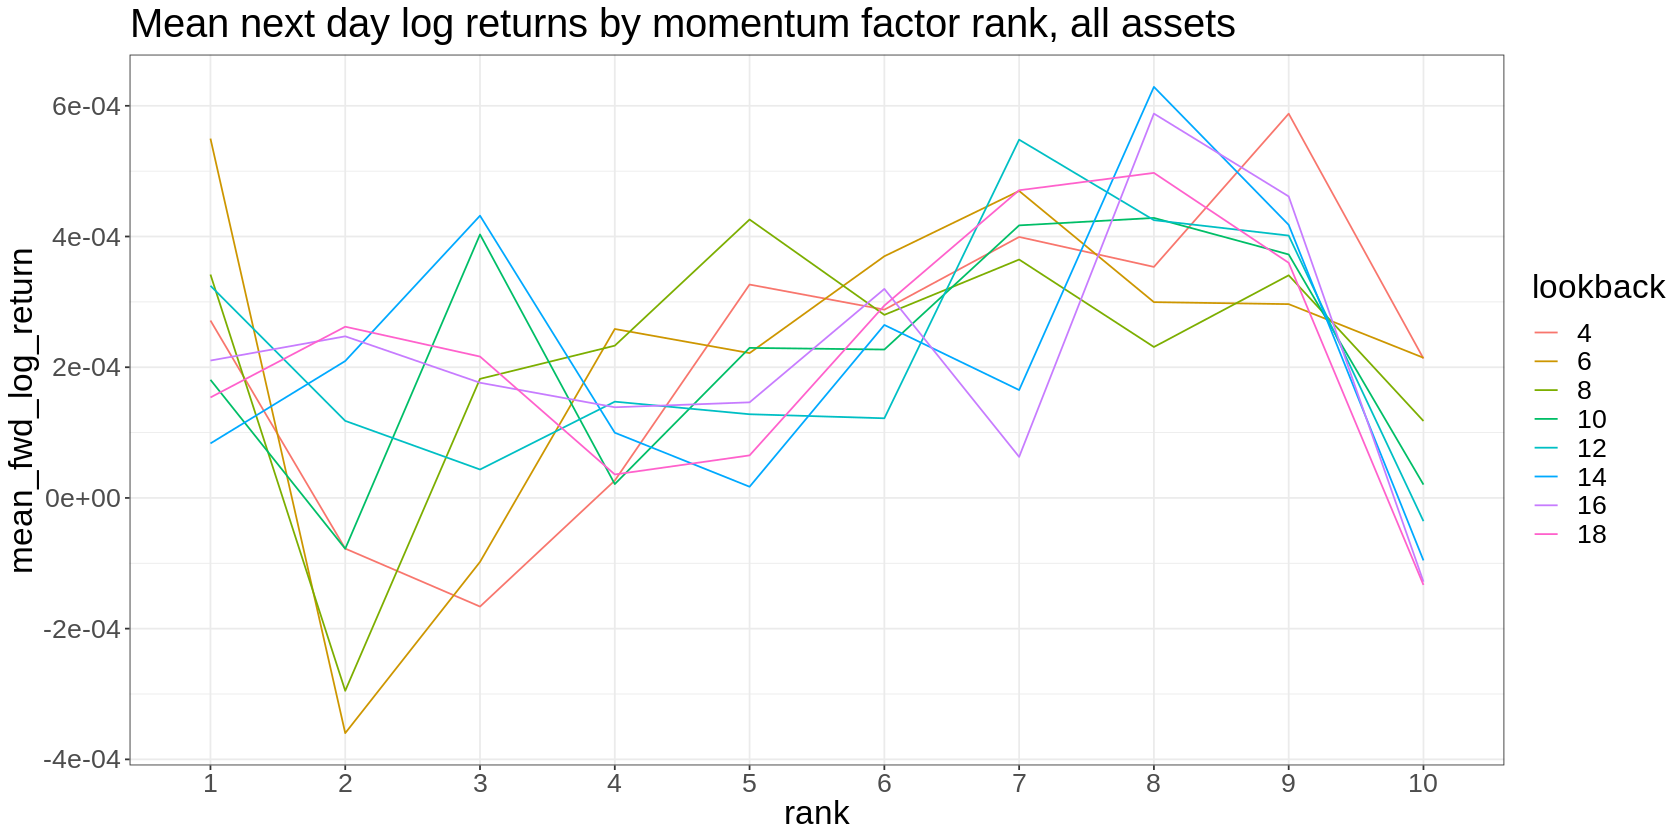

In [8]:
momo %>%
  group_by(lookback, rank) %>%
  summarise(mean_fwd_log_return = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_return, colour = lookback, group = lookback)) + 
    geom_line() + 
    ggtitle('Mean next day log returns by momentum factor rank, all assets')

Visualise by factor plots facetted by lookback:

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


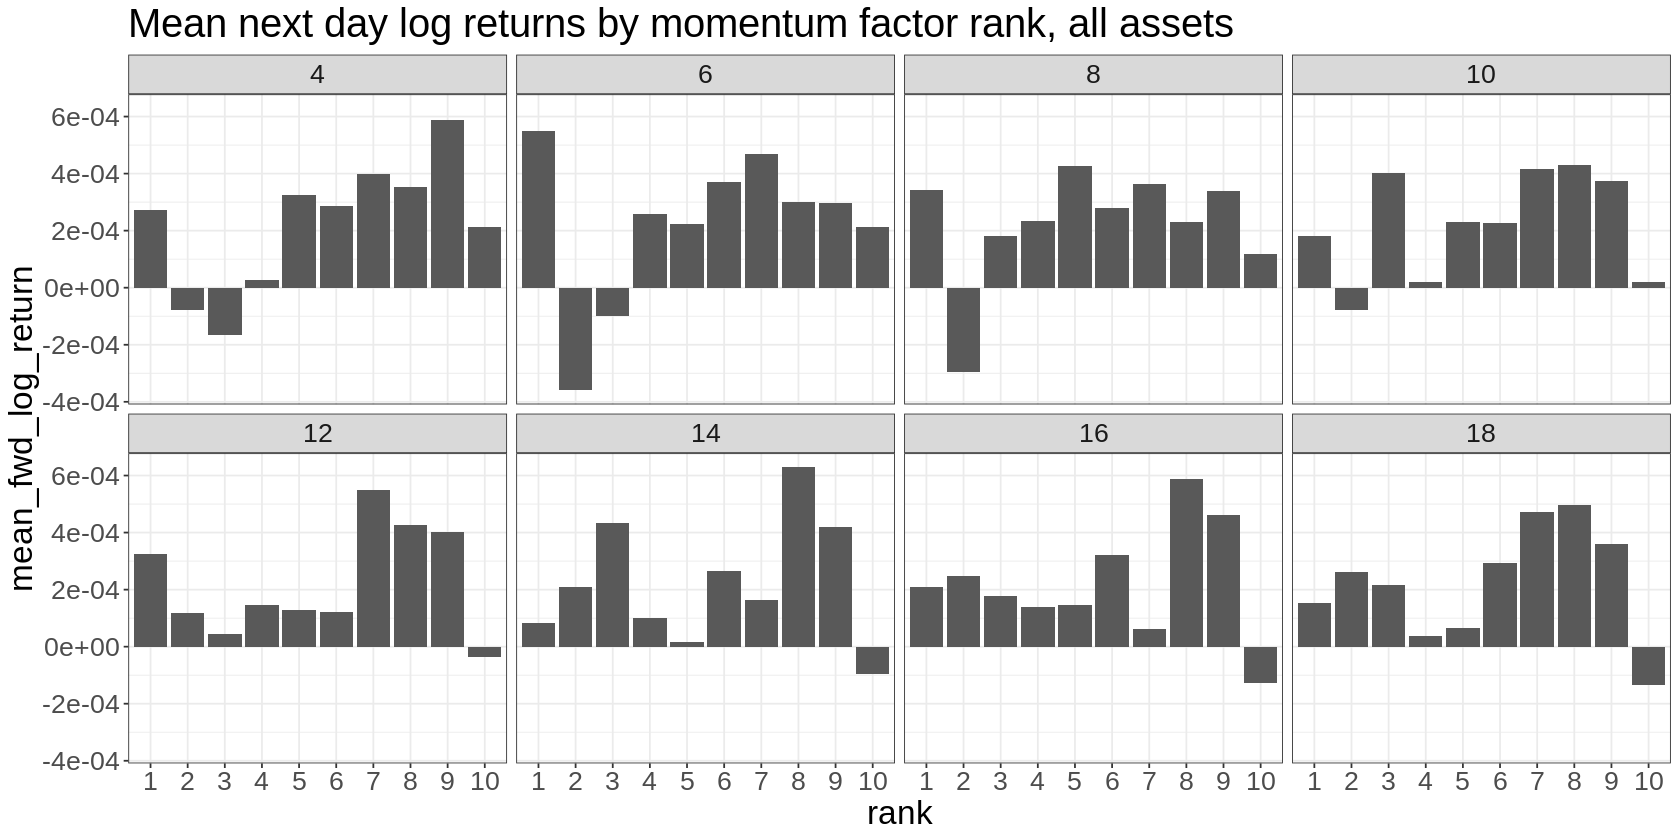

In [9]:
momo %>%
  group_by(lookback, rank) %>%
  summarise(mean_fwd_log_return = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_return)) + 
    geom_bar(stat = "identity") + 
    ggtitle('Mean next day log returns by momentum factor rank, all assets') +
    facet_wrap(~lookback, nrow = 2)

### Full history factor sort 

Now we can do some simple analysis over the full data sample...

Look more closely at each asset. 

For each lookback, take each observation and ignore the date it appeared on.

Group each observation by rank and plot the mean next day log return for each rank and ticker.

If it increases with increasing rank we have some evidence of a time-series momentum effect at the asset-class level, at least over the whole history.

`summarise()` has grouped output by 'ticker', 'lookback'. You can override
using the `.groups` argument.


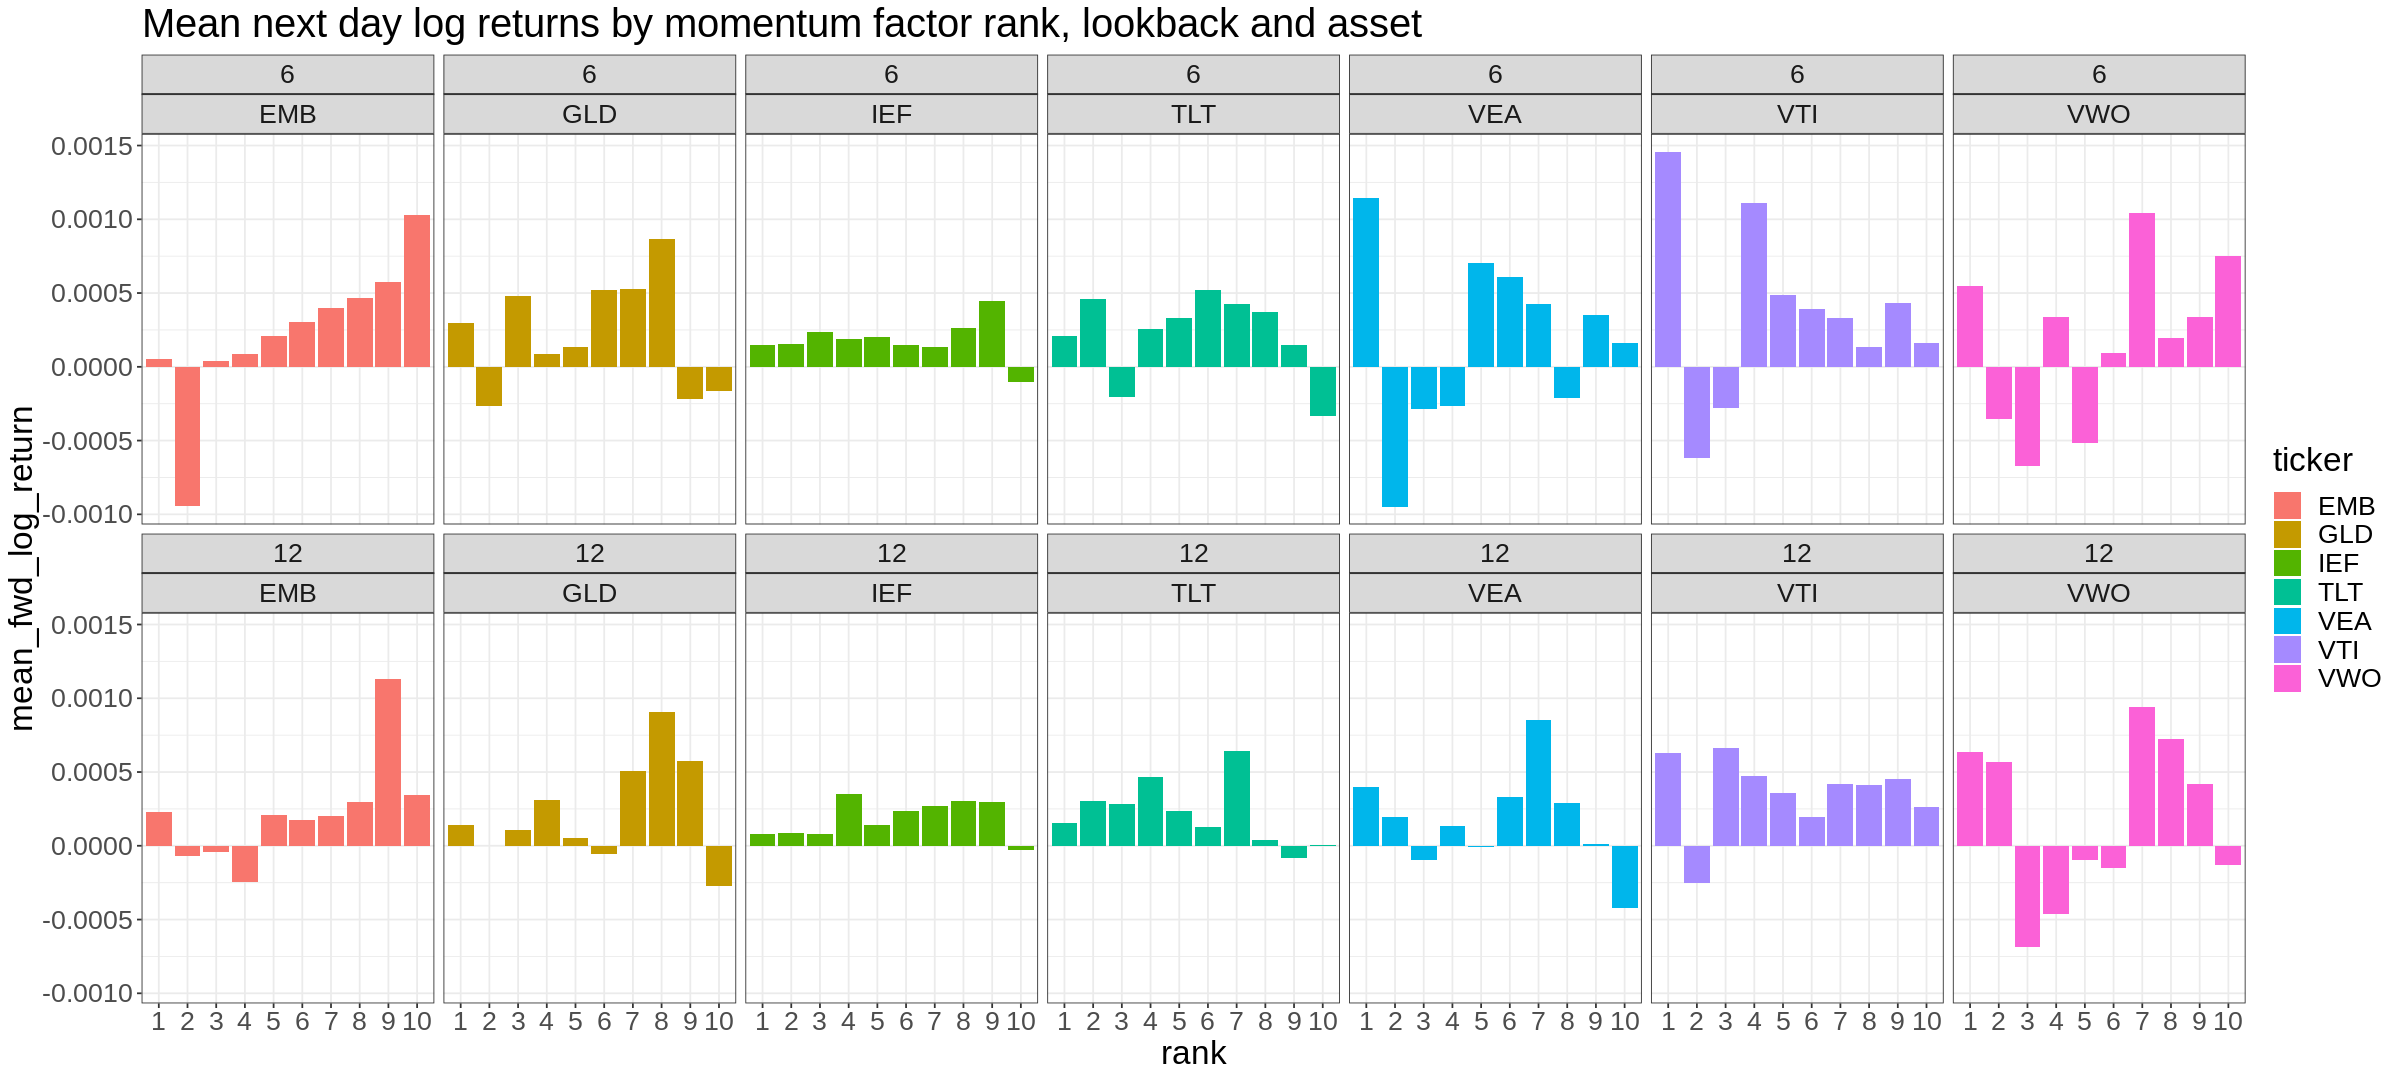

In [10]:
options(repr.plot.width = 20, repr.plot.height=9)

momo %>%
  dplyr::filter(lookback %in% c(6, 12)) %>%
  group_by(ticker, lookback, rank) %>%
  summarise(mean_fwd_log_return = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_return, fill = ticker)) + 
    geom_bar(stat = "identity") + 
    ggtitle('Mean next day log returns by momentum factor rank, lookback and asset') +
    facet_wrap(~lookback + ticker, nrow = 2)

We see quite different effects for different tickers. 

- EMB is interesting. 
- Could argue that VEA and VTI tend to show a reversion effect. 
- GLD, IEF, TLT arguably show noisy momentum effect, but revert at extremes. 

Might be interesting to see a time series representation by ticker.

- Create a continuous and comparable-between-assets time series momentum factor: scale by its own standard deviation, and restrict to max/min bounds if necessary. 
- Weight a position according to value of of factor
- Plot time-series returns by asset

In [11]:
momo_strat <- momo %>%
  group_by(ticker, lookback) %>%
  mutate(scaled_mom = momo / roll_sdr(momo, 126)) %>%
  # allow it to get to +/- 1.5
  mutate(weight = 0.5 * pmax(pmin(scaled_mom, 3), -3)) %>% 
  na.omit() %>%
  mutate(
    strat_return = fwd_log_return * weight,
    cumret = cumsum(strat_return)
  )

tail(momo_strat)

ticker,date,open,high,low,close,volume,closeadjusted,fwd_log_return,fwd_simple_return,lookback,momo,rank,scaled_mom,weight,strat_return,cumret
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
VWO,2023-04-19,40.37,40.45,40.273,40.38,6359230,40.38,-0.001239004,-0.001238237,8,0.005828725,5,0.06121757,0.03060879,-3.792441e-05,1.448583811
VWO,2023-04-19,40.37,40.45,40.273,40.38,6359230,40.38,-0.001239004,-0.001238237,10,-0.049971767,4,-0.58587740,-0.29293870,3.629522e-04,1.125610331
VWO,2023-04-19,40.37,40.45,40.273,40.38,6359230,40.38,-0.001239004,-0.001238237,12,-0.105885479,3,-1.76837906,-0.88418953,1.095514e-03,0.408705269
VWO,2023-04-19,40.37,40.45,40.273,40.38,6359230,40.38,-0.001239004,-0.001238237,14,-0.132676074,3,-3.17696274,-1.50000000,1.858506e-03,-0.007242634
VWO,2023-04-19,40.37,40.45,40.273,40.38,6359230,40.38,-0.001239004,-0.001238237,16,-0.159537933,2,-2.92388959,-1.46194479,1.811355e-03,-0.524953717
VWO,2023-04-19,40.37,40.45,40.273,40.38,6359230,40.38,-0.001239004,-0.001238237,18,-0.150467054,2,-4.01034638,-1.50000000,1.858506e-03,-0.314367597


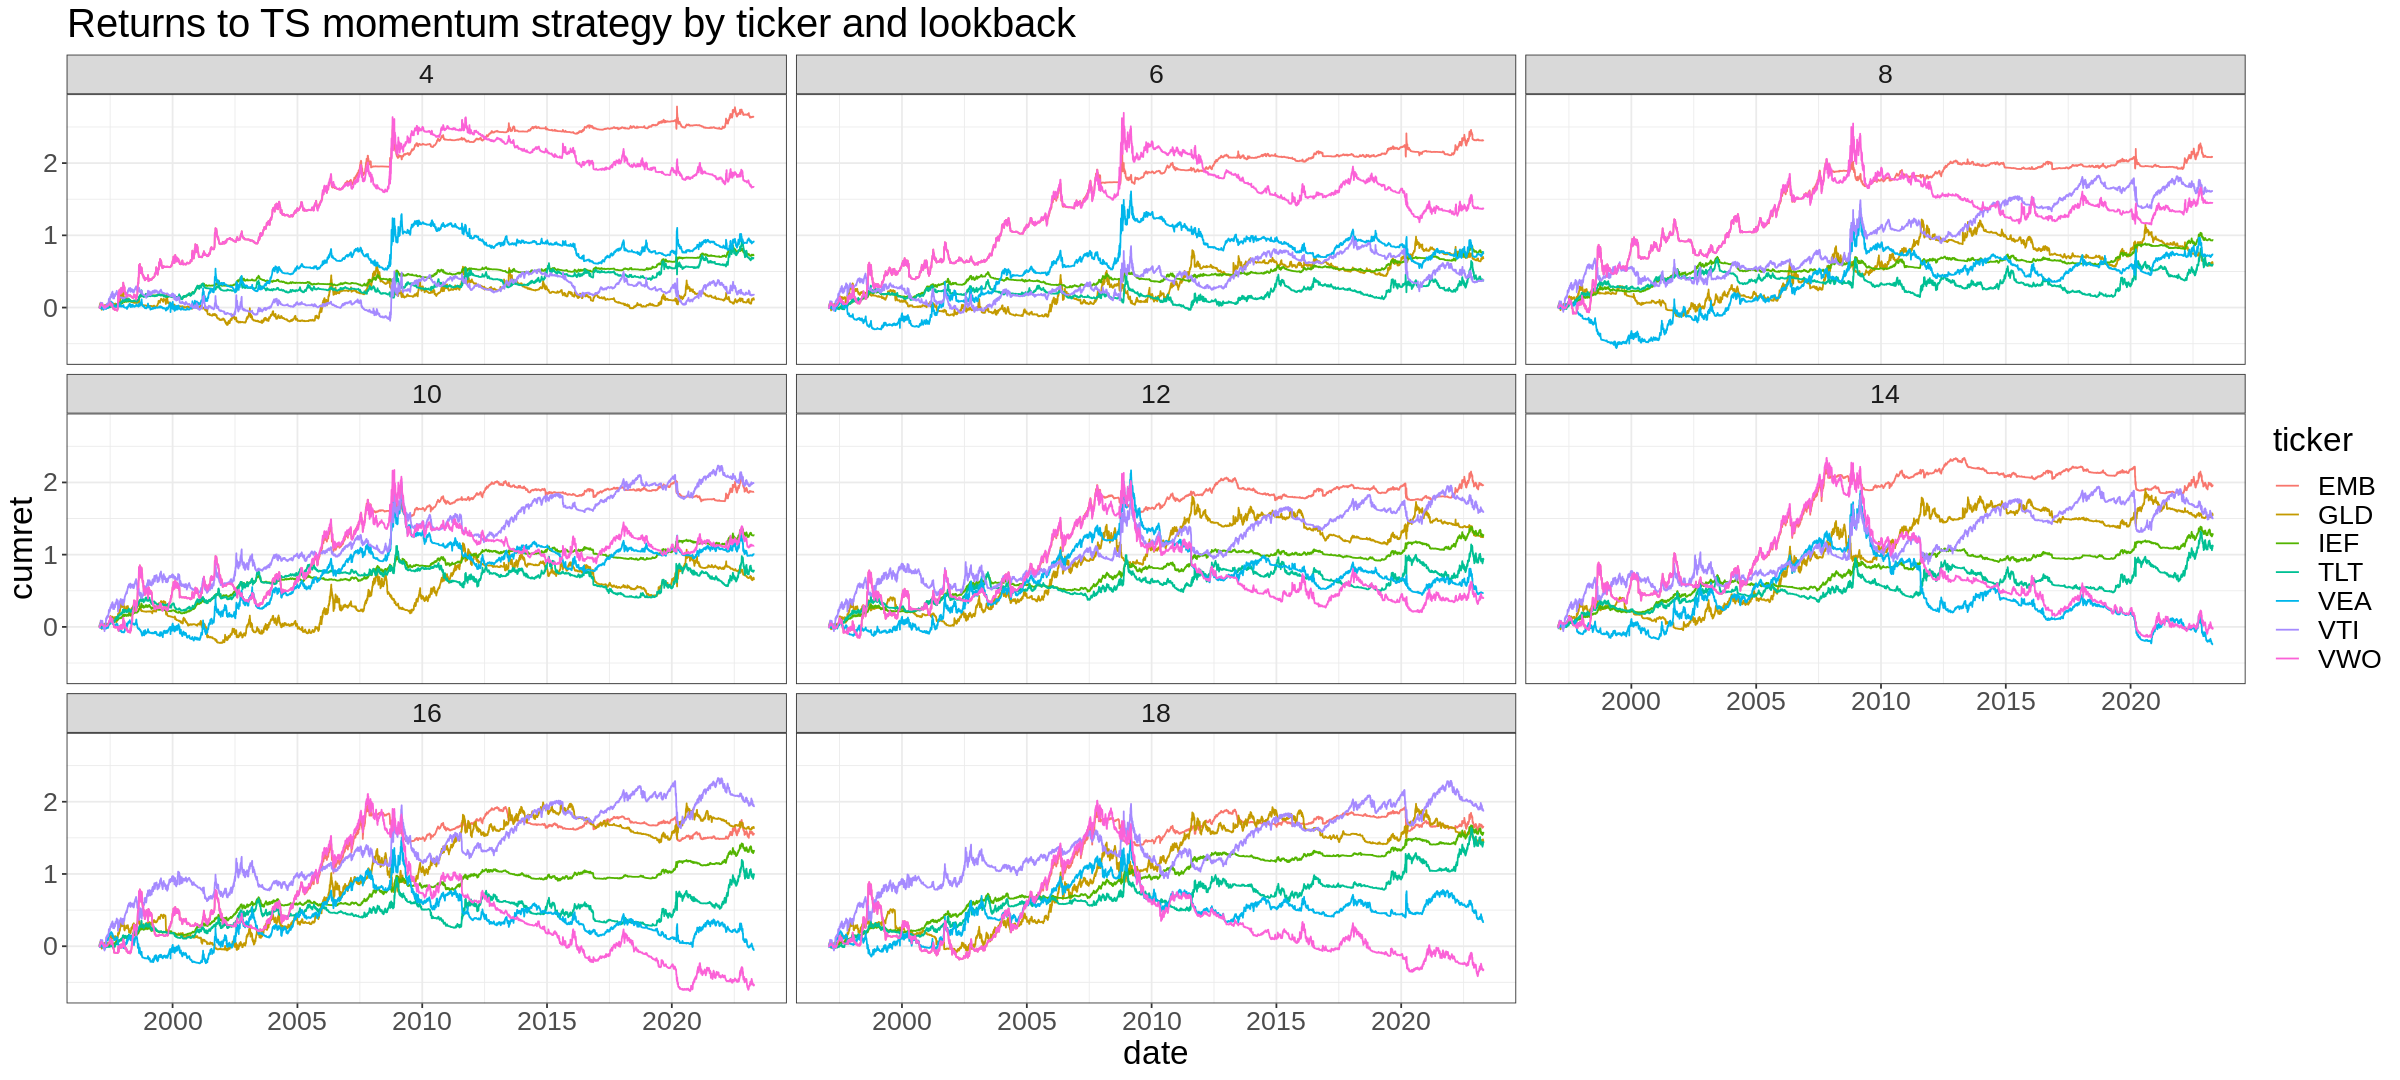

In [12]:
momo_strat %>%
  ggplot(aes(x = date, y = cumret, colour = ticker)) +
    geom_line() +
    facet_wrap(~lookback) +
    labs(
    title = "Returns to TS momentum strategy by ticker and lookback"
    )

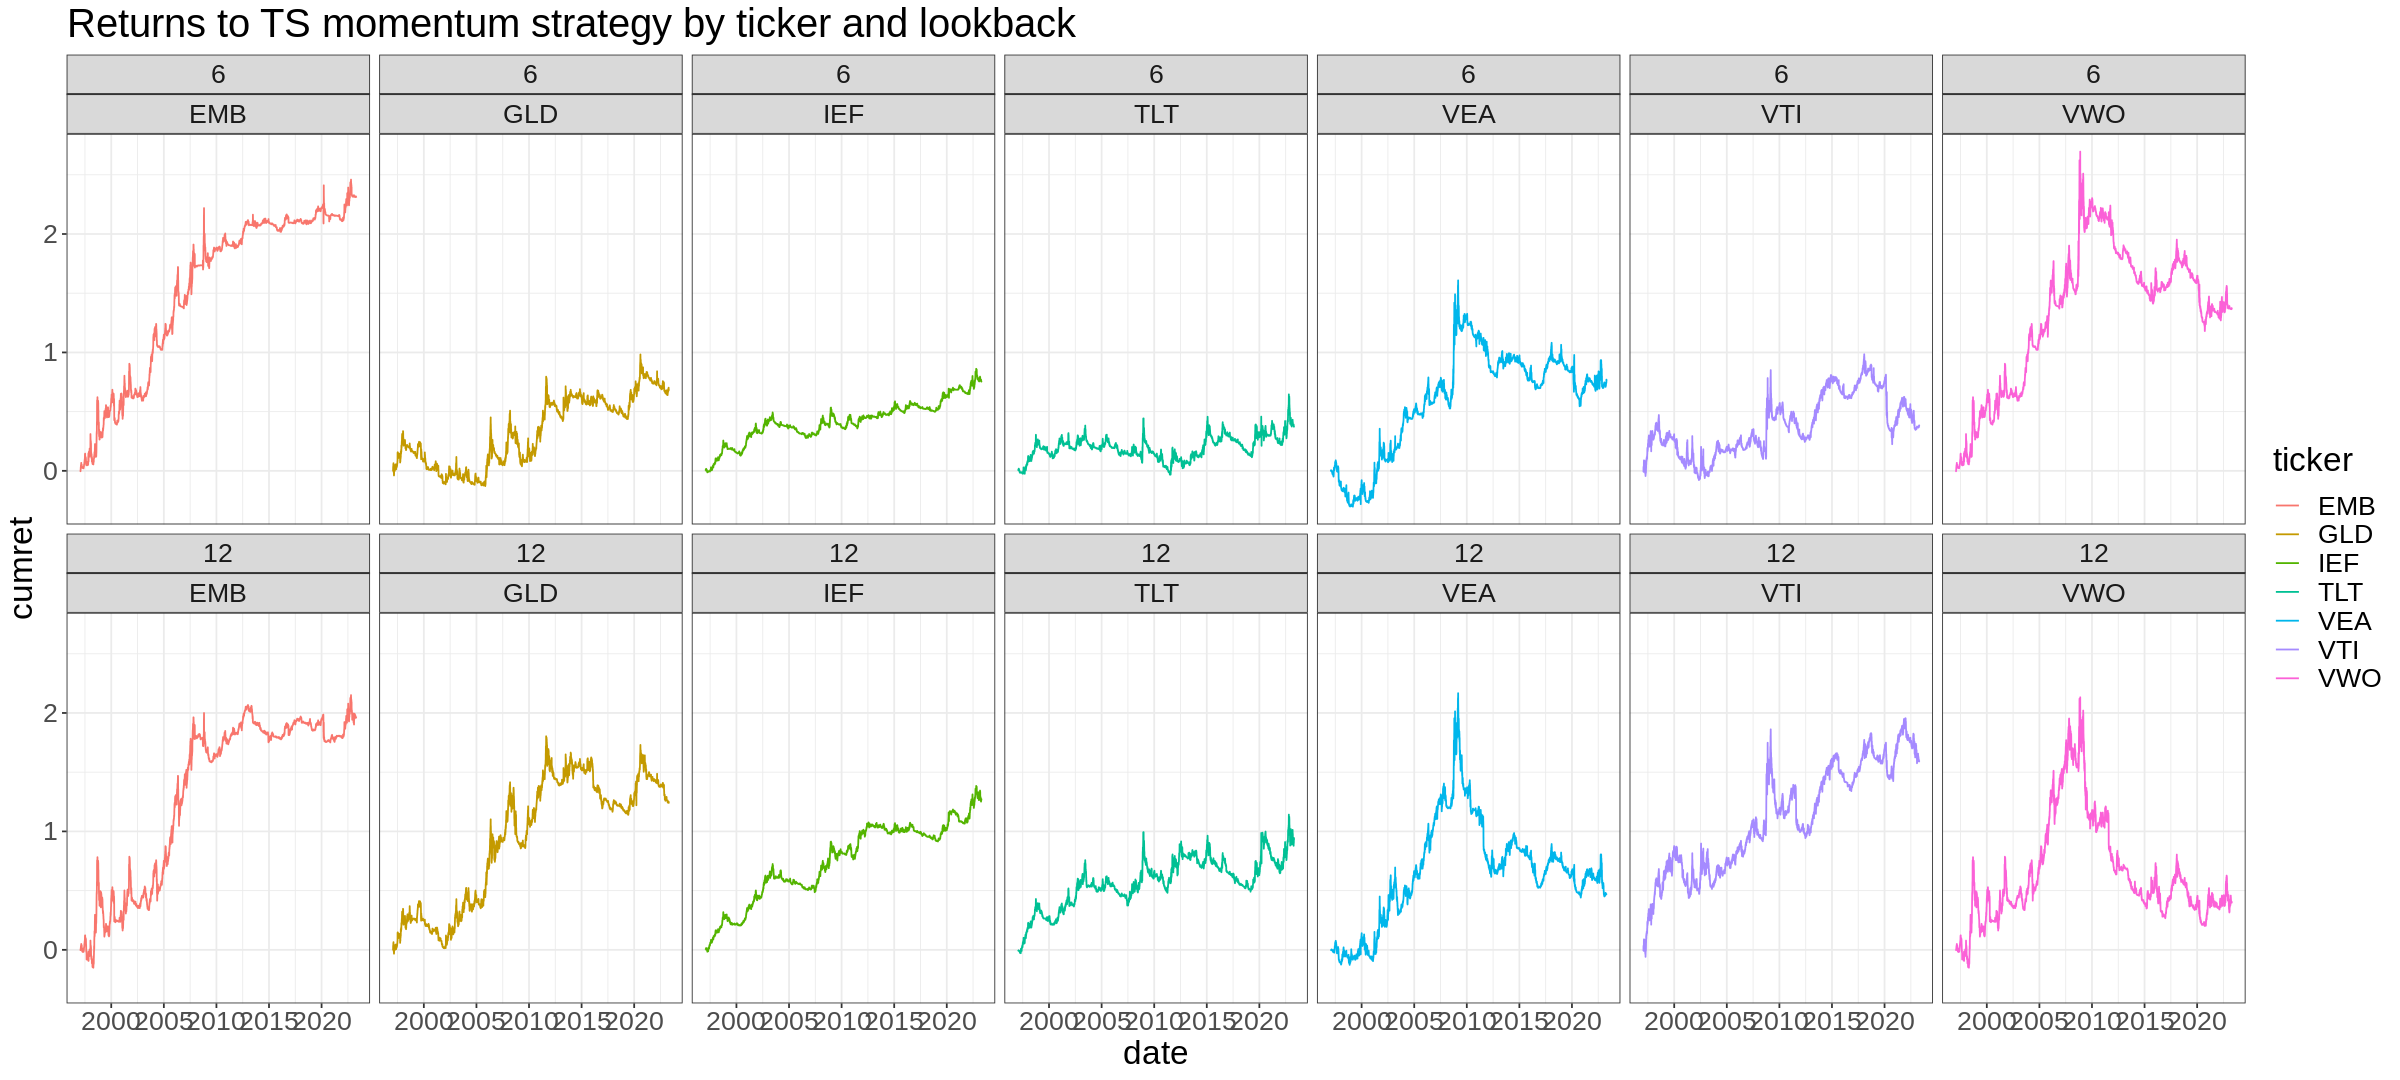

In [13]:
momo_strat %>%
  filter(lookback %in% c(6, 12)) %>%
  ggplot(aes(x = date, y = cumret, colour = ticker)) +
    geom_line() +
    facet_wrap(~lookback + ticker, nrow = 2) +
    labs(
    title = "Returns to TS momentum strategy by ticker and lookback"
    )

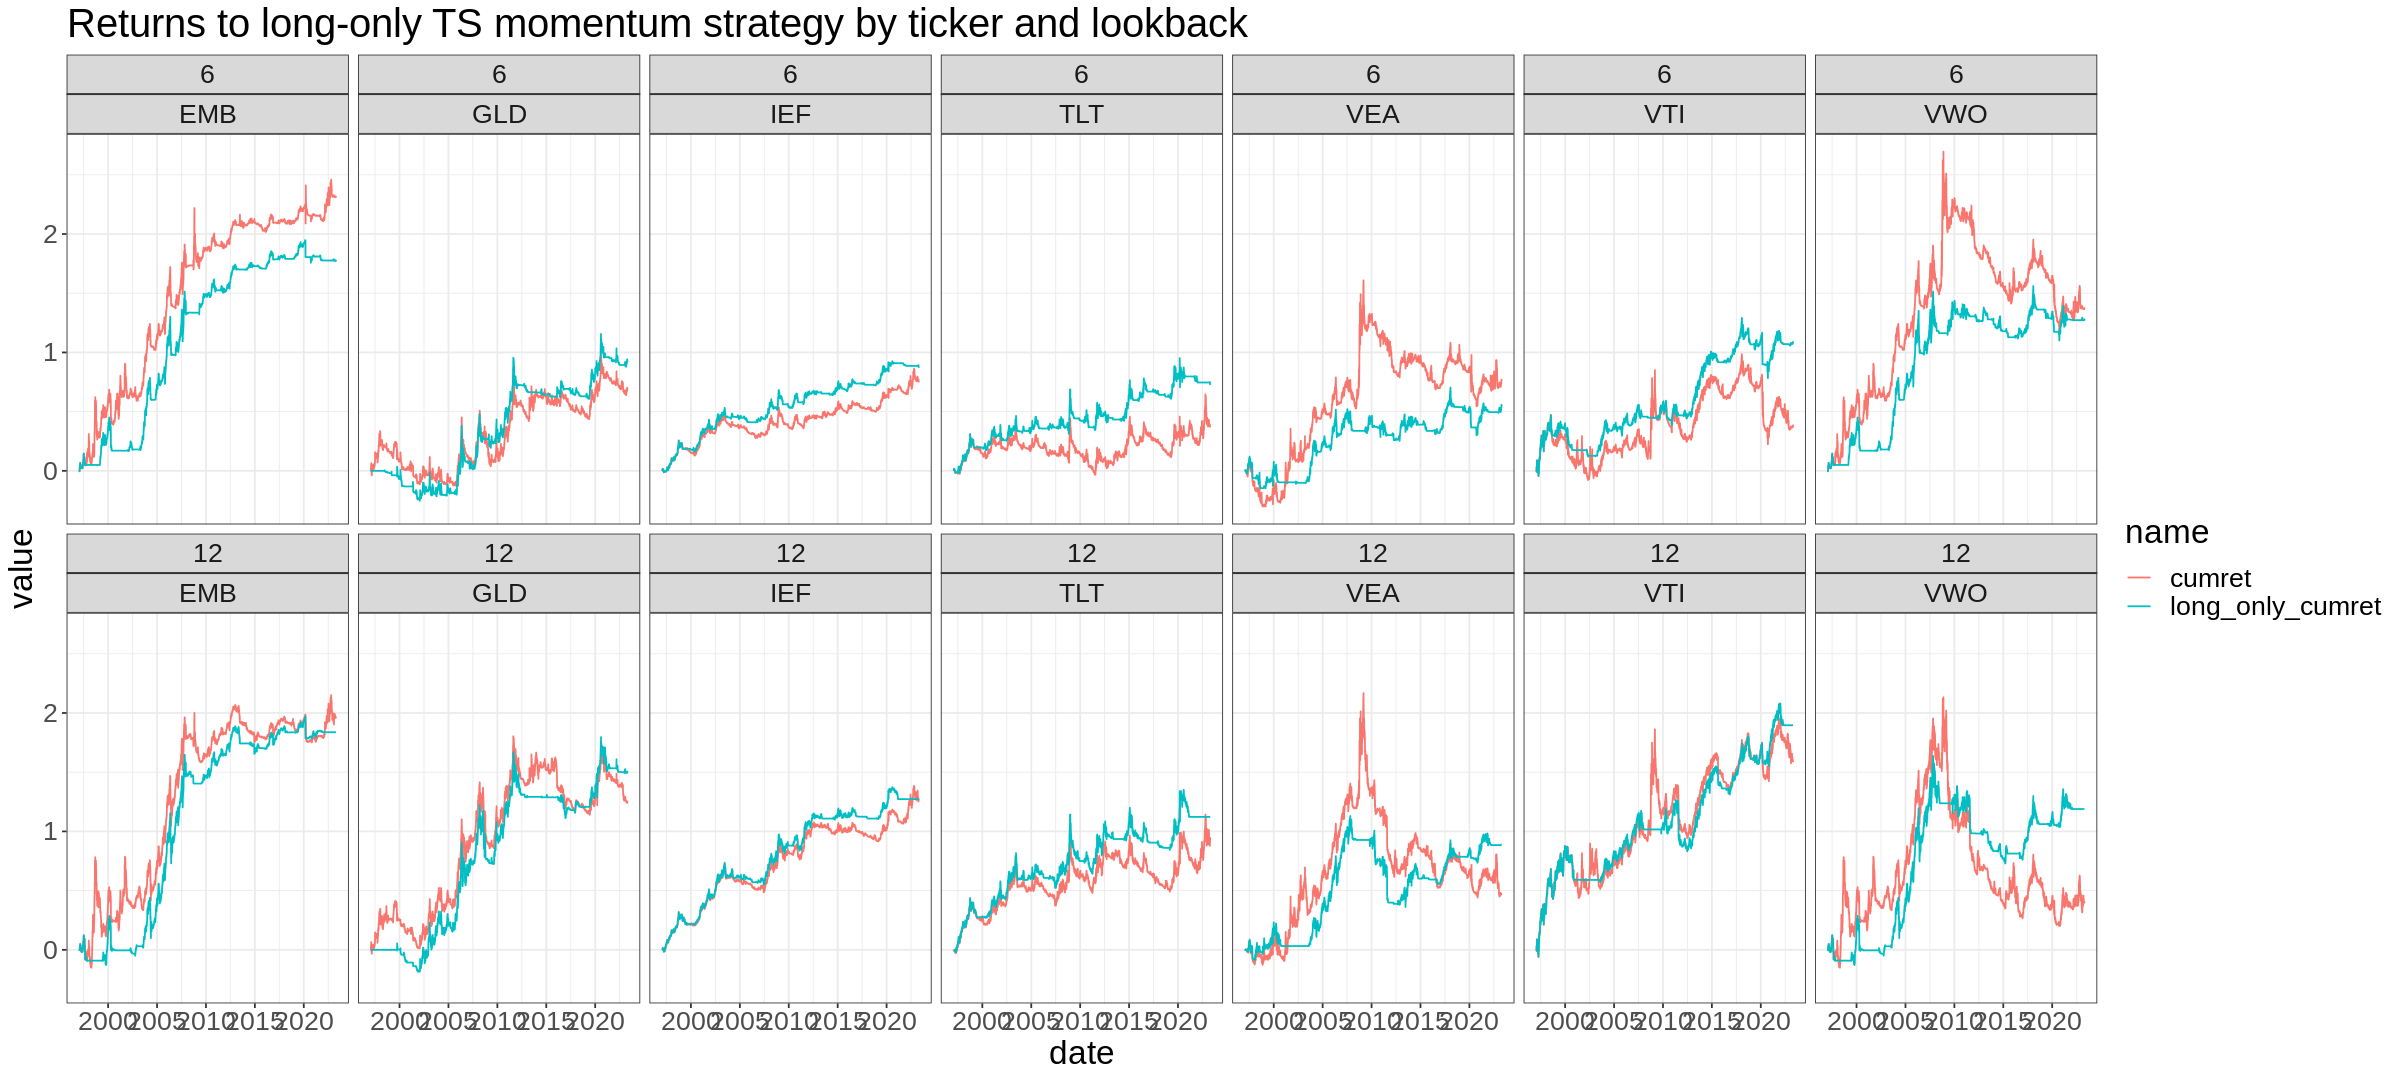

In [14]:
# long only

momo_strat <- momo_strat %>%
  group_by(ticker, lookback) %>%
  # allow it to get to +/- 1.5
  mutate(long_only_weight = 0.5 * pmax(pmin(scaled_mom, 3), 0)) %>% 
  na.omit() %>%
  mutate(
    long_only_strat_return = fwd_log_return * long_only_weight,
    long_only_cumret = cumsum(long_only_strat_return)
  )

momo_strat %>%
  filter(lookback %in% c(6, 12)) %>%
  pivot_longer(c(cumret, long_only_cumret)) %>%
  ggplot(aes(x = date, y = value, colour = name)) +
    geom_line() +
    facet_wrap(~lookback + ticker, nrow = 2) +
    labs(
    title = "Returns to long-only TS momentum strategy by ticker and lookback"
    )

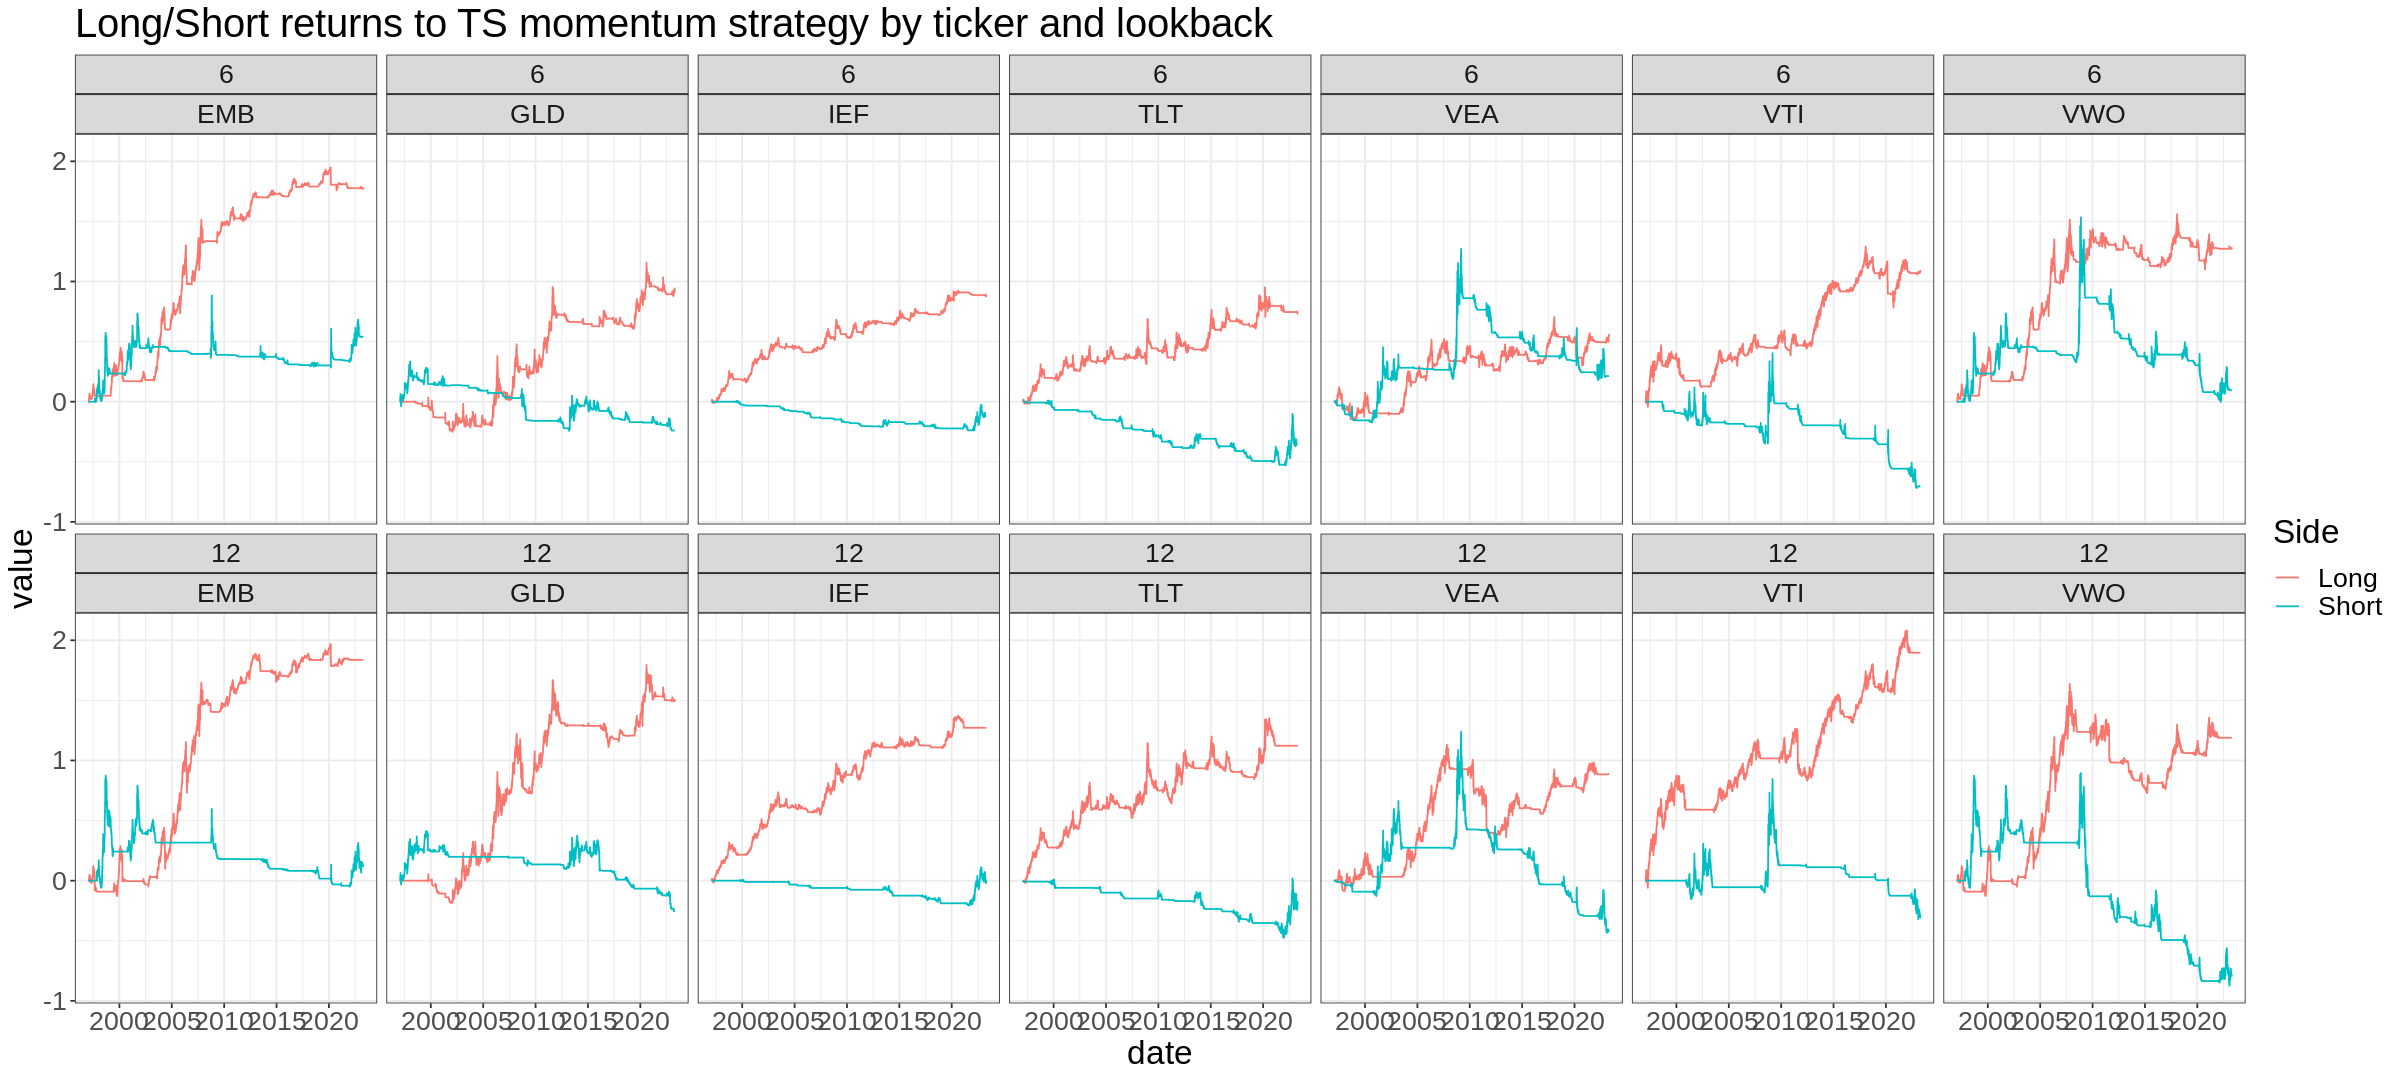

In [15]:
# short only

momo_strat <- momo_strat %>%
  group_by(ticker, lookback) %>%
  # allow it to get to +/- 1.5
  mutate(short_only_weight = 0.5 * pmax(pmin(scaled_mom, 0), -3)) %>% 
  na.omit() %>%
  mutate(
    short_only_strat_return = fwd_log_return * short_only_weight,
    short_only_cumret = cumsum(short_only_strat_return)
  )

# long only and short only 
momo_strat %>%
  filter(lookback %in% c(6, 12)) %>%
  pivot_longer(c(short_only_cumret, long_only_cumret)) %>%
  ggplot(aes(x = date, y = value, colour = name)) +
    geom_line() +
    scale_colour_discrete(labels=c('Long', 'Short')) +
    facet_wrap(~lookback + ticker, nrow = 2) +
    labs(
      title = "Long/Short returns to TS momentum strategy by ticker and lookback",
      colour = "Side"
    )

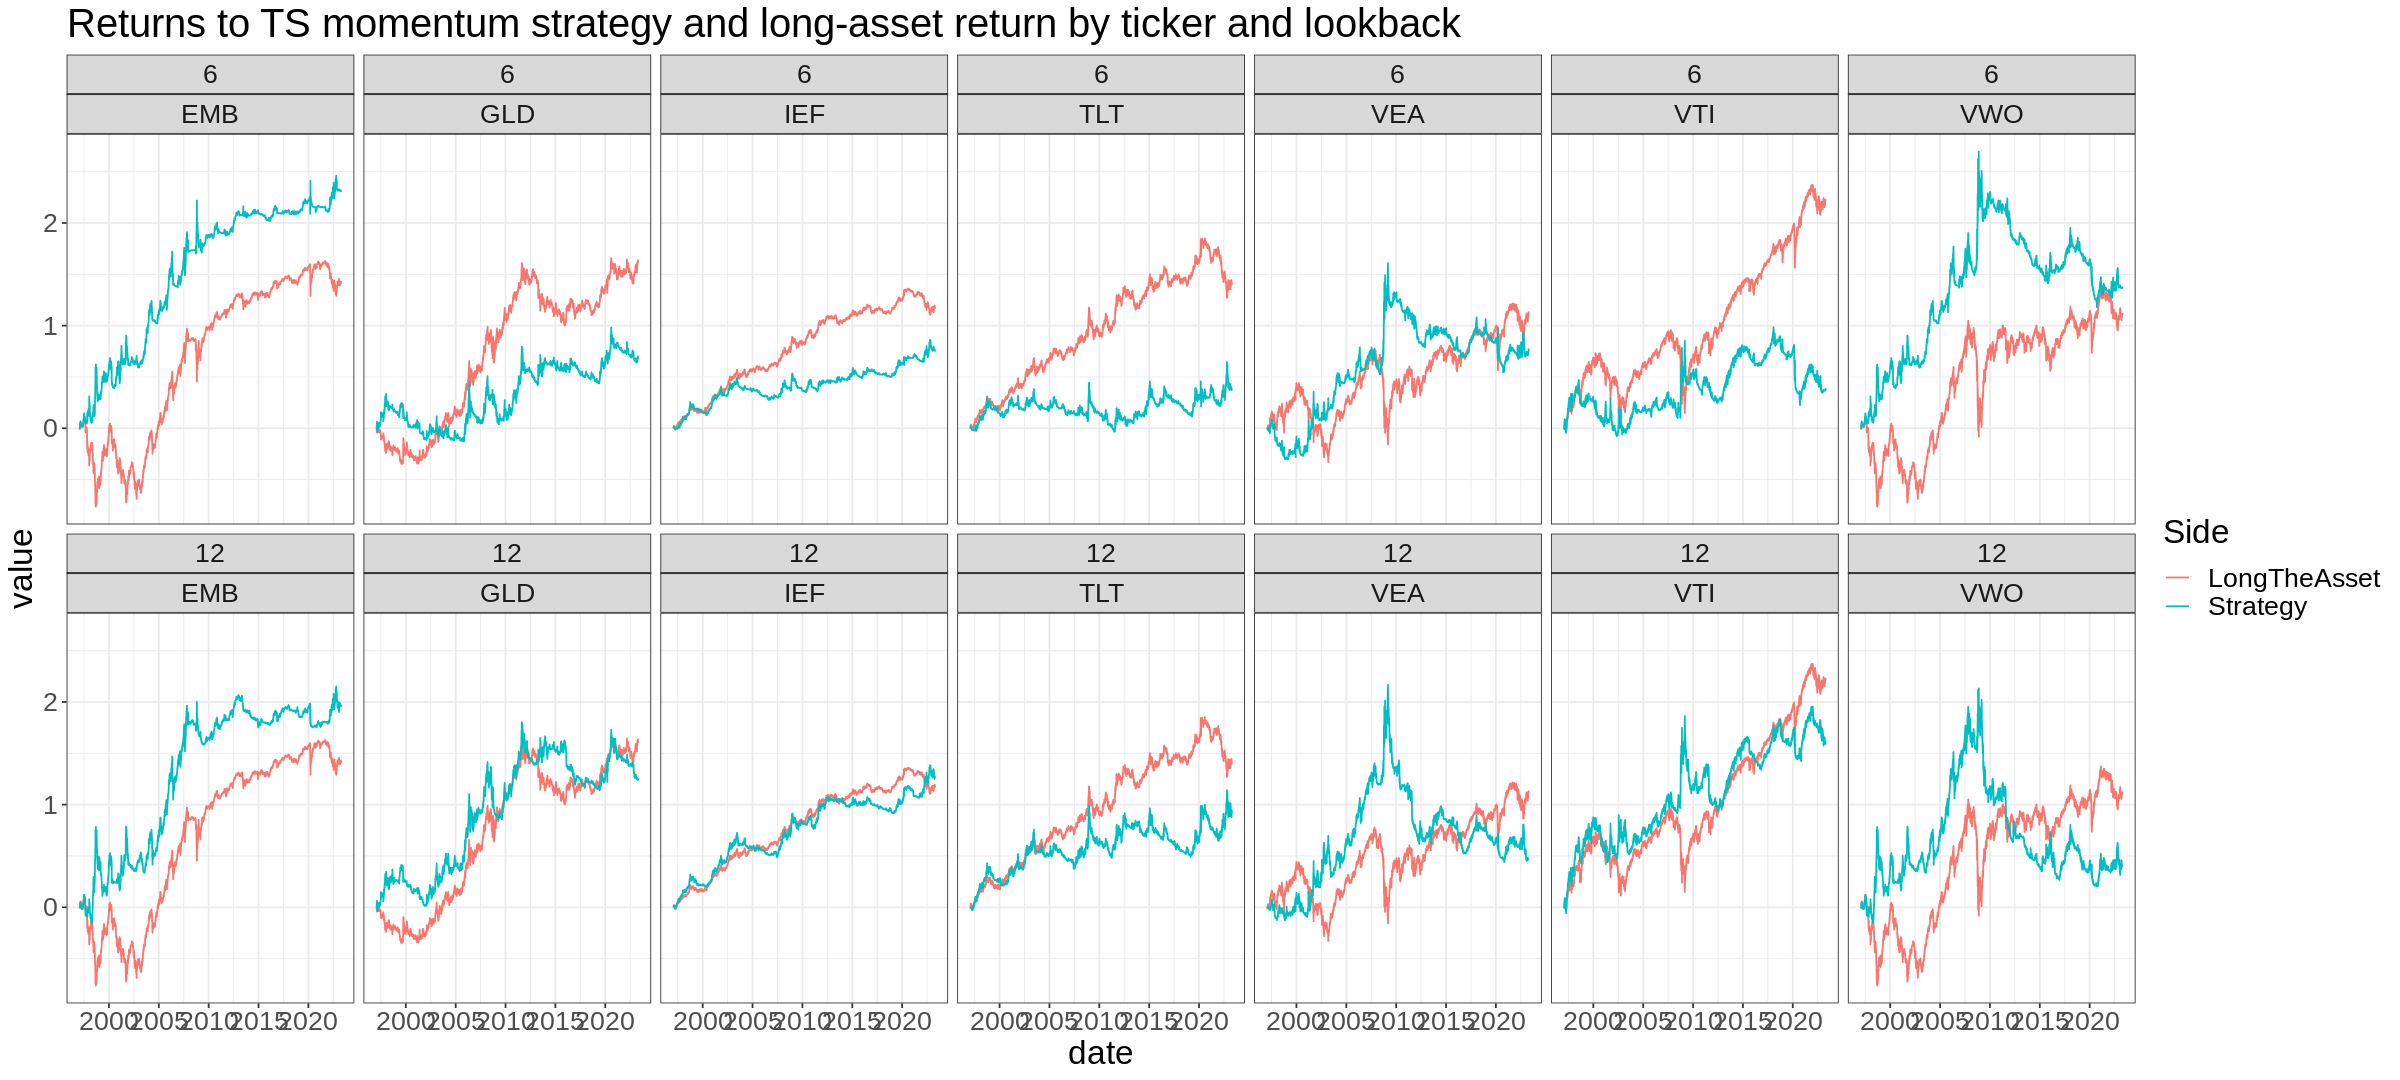

In [19]:
# strategy vs long the asset
momo_strat %>%
  group_by(ticker, lookback) %>%
  mutate(asset_returns = cumsum(fwd_log_return)) %>%
  filter(lookback %in% c(6, 12)) %>%
  pivot_longer(c(cumret, asset_returns)) %>%
  ggplot(aes(x = date, y = value, colour = name)) +
    geom_line() +
    scale_colour_discrete(labels=c('LongTheAsset', 'Strategy')) +
    facet_wrap(~lookback + ticker, nrow = 2) +
    labs(
      title = "Returns to TS momentum strategy and long-asset return by ticker and lookback",
      colour = "Side"
    )